# Multivariate Statistik und Machine Learning: Assignment 3

The exercises on this sheet are graded by a maximum of 10(+1) points. You will be asked to implement several functions.

Team work is not allowed. Everybody implements his/her own code. Discussing issues with others is fine, sharing code with others is not. 

If you use any code fragments found on the Internet, make sure you reference them properly.



**Note: Please do not upload the folder `materials` in your moodle submission.**

**Note: you might need to install the cv2 package. you can do so by running `pip install opencv-contrib-python`, otherwise see conda documentation.**


## Exercise 1 --- Regression (2 Points)

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from utils import *

C:\Users\Ketzel\Documents\GitHub\Multivariate-Statistics-and-Machine-Learning\Exercise03\utils.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  theta = np.linalg.lstsq(X_ex, Y)[0]


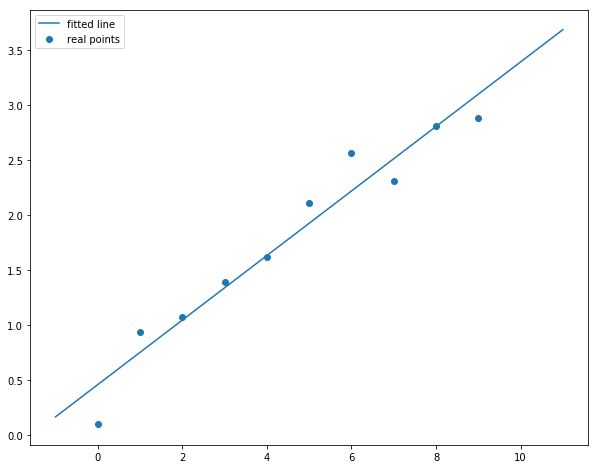

In [7]:
lineardemo()

### 1.1 --- Regression

In this exercise you are given a timeseries (just some observations) that was artificially generated (see file  timeseries.csv). It was obtained combining some known to me and unknown to you polynomial (e.g. y(t)=t2+2 y(t) = t^2 + 2y(t)=t2+2) plus some random noise. Your task is to find the parameters of the polynomial model that was used.

Use `pandas.read_csv('./materials/timeseries.csv')` to load the data. In order to visualize data use `plt.plot(timeseries)`.

Polynomial fitting is a traditional application of linear regression. Implement function `ii_fit_poly` that fits a polynomial to the input data. The function should take three arguments: the input data (as a column vector), a column vector of target values, and the desired degree of the polynomial (a non-negative integer). Return your estimated
model (theta).

Also, implement function `ii_apply_poly` that takes two arguments: a model (as returned by your function `ii_fit_poly`) and a column vector of points on which to evaluate the model. Return the estimated values as a column vector.

A helper function that extends the feature vector with the polynomial terms (computes $X_\text{ext}$ from $X$ for a given degree) might be useful, as polynomial fits are also going to be used in later exercises. You can use function test_poly to test your implementation.

You have to research which degree works better (in a range $[1, 10]$) and report it.

In [8]:
def Calculat_Xext(X,degree):
    return np.array([X**deg for deg in range(0,degree+1)]).T

In [9]:
def ii_fit_poly(X, y, degree):
    X_extend = Calculat_Xext(X,degree)
    
    theta = np.linalg.lstsq(X_extend, y, rcond= None)[0]
        
    return np.array(theta)

In [10]:
def ii_apply_poly(theta, X):
    y_hat = np.zeros(X.shape[0])

    for i in range(0,theta.shape[0]):
        y_hat += theta[i]*X**i
    
    return y_hat

In [11]:
from sklearn.metrics import mean_squared_error
def test_poly():
    degrees = np.arange(1,10) ## changed

    timeseries = np.loadtxt('./materials/timeseries.csv')
    print(timeseries.dtype)
    x = timeseries[:, 0]
    y = timeseries[:, 1]

    labels = ['Degree {}'.format(i) for i in degrees]
    plt.scatter(x, y, label='Data')

    for i in range(len(degrees)):
        theta = ii_fit_poly(x, y, degrees[i])
        estimated_y = ii_apply_poly(theta, x)
        plt.plot(x, estimated_y, label=labels[i])
        ## added to find the best fit
        RMSE = mean_squared_error(y,estimated_y, squared=False)
        print(f"RMSE for degree {degrees[i]}: {RMSE}") 

    plt.legend(loc='best')
    plt.title('Poly fit')

float64
RMSE for degree 1: 222106.9057925093
RMSE for degree 2: 98761.92391846955
RMSE for degree 3: 29632.565098155686
RMSE for degree 4: 5387.517822794167
RMSE for degree 5: 449.49494369404914
RMSE for degree 6: 2.565116846500957
RMSE for degree 7: 2.5625446432222567
RMSE for degree 8: 2.5586586393654875
RMSE for degree 9: 2.5586252664907563


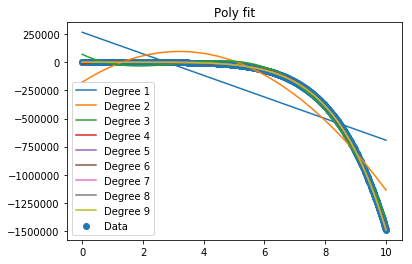

In [12]:
test_poly()

In [13]:


#### Answer: The Polynomial fit for degree = 9 is the best fit because the RMSE between the estimated y and the originial data is the smallest

### 1.2 --- Ridge regression

Regularization is important for avoiding overfitting on a noisy data input.

* Implement function `ii_fit_poly_ridge` that fits a polynomial to the input data using ridge regression. It should take the same arguments as `ii_fit_poly`, except for an additional argument which is the regularization strength $\lambda$.

You can use ridge regression from here `sklearn.linear_model.ridge_regression`.

You can use function `test_poly_ridge` to test your implementation.

* Try to regularize your model for the Exercise 1 problem.

* Experiment how $\lambda$ influences the quality of your model(to do that you can try to use cross-validation that is not compulsory, but strongly recommended).

* Provide the parameters of your best model.

In [14]:
from sklearn.linear_model import ridge_regression

In [15]:
 def ii_fit_poly_ridge(X, y, degree, lam = 1):
    #this code was inspired by: https://anujkatiyal.com/blog/2017/09/30/ml-regression/#.XnNvuKhKhPY
        
    x_transform = Calculat_Xext(X,degree)

    xtranspose = np.transpose(x_transform)
    xtransx = np.dot(xtranspose,x_transform)
    lamidentity = np.identity(xtransx.shape[0])
    lamidentity = lamidentity * lam
    matinv = np.linalg.inv(lamidentity + xtransx)
    xtransy = np.dot(xtranspose, y)
    wRR = np.dot(matinv, xtransy)
    
    return wRR
    

In [16]:
from sklearn.model_selection import KFold #imported for cross validation
from sklearn.metrics import mean_squared_error

def test_poly_ridge():
    degree = 6
    lambdas = [0,10,100,200, 500, 1000]
    plt.figure(figsize=(10, 8))

    ts = np.loadtxt('./materials/timeseries.csv')
    x = ts[:, 0]
    y = ts[:, 1]

    labels = ['Lambda {}'.format(i) for i in lambdas]
    plt.scatter(x, y, label='Data')
    
    ## cross validation
    cv = KFold(n_splits=5) ## n - Fold 
    RMSE_avg = [] ## List of the average root mean squared error
    

    for i in range(len(lambdas)):
        RMSE = [] ## Root mean squared error for the corresponding lambda
        for train_index, test_index in cv.split(x):
        
            theta = ii_fit_poly_ridge(x[train_index], y[train_index], degree, lambdas[i])
            estimated_y = ii_apply_poly(theta, x[test_index])
            ##RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred))) ## if you don't have the current sklean version
            RMSE.append(mean_squared_error(y[test_index], estimated_y, squared = False))
            plt.plot(x[test_index], estimated_y, label=labels[i])
            
        RMSE_avg.append(np.mean(RMSE))
        print(f"Average RMSE for lambda = {lambdas[i]}:       {RMSE_avg[i]}") 
            
        
    
    plt.title('Ridge poly fit')
    plt.legend(loc='best')
    #plt.savefig('a.png')

Average RMSE for lambda = 0:       7.402811435609111
Average RMSE for lambda = 10:       6.202355970675356
Average RMSE for lambda = 100:       5.5376597128068665
Average RMSE for lambda = 200:       5.879701676271889
Average RMSE for lambda = 500:       10.441583056526119
Average RMSE for lambda = 1000:       19.41430937599591


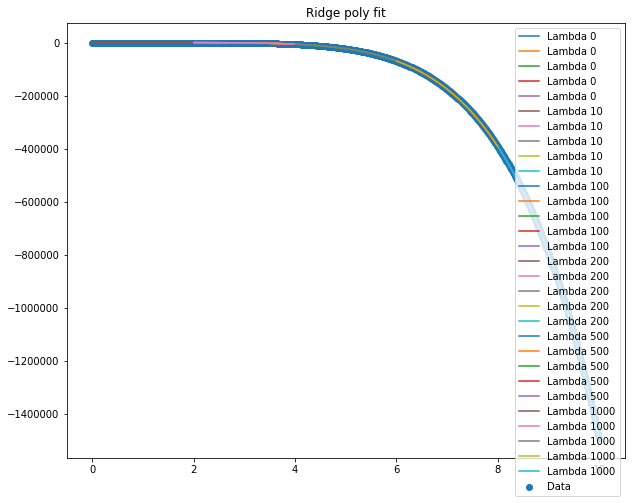

In [17]:
test_poly_ridge()

In [18]:
### Model Parameters for the best model: lambda = 100, degree = 6 with an averae RMSE: 5.5376597128068665

## Exercise 2 --- Face Prediction (2 + 1 Points)

(i) Here we are going to reconstruct right part of human face from the left part of a human face. We will use linear regression to model the right part of the human face as a function of the corresponding left part. Implement function `ii_predict_face` that takes two arguments: a training dataset and a query image with no right part of the face.

Training dataset consists of full (left and right part are both there) images of size ($231\times395$). From those images you have to extract labels (right parts) and construct a dataset in the way that will allow you to apply squared error minimization method. The images in the provided dataset are stacked along the third axis (if you imagine what is the shape of the data - the answer would be [number of images, image length, image width]).

You can visualize an image with function `plt.imshow(image)`. The function should return predicted right part with the same shape as the query has (see below).

Using the data from the training dataset, learn a linear regression model with the right part of the image as the output value and the left part of the image as input value. You can use `C1=dataset[:, :198, :)` to extract the left part of the images in the dataset.

In order to get the shape of the data use function `data.shape`.

Your output vector in the linear regression ($Y$ in the intro) should be a $N \times length \times width/2$ matrix, your input matrix ($X_\text{ext}$) should be $N \times length \times width/2 + 1$, with ones in the last column and raveled images in the columns left.

After you determined the model $\theta$, estimate the right part of the face using your model. You can use `v.reshape([num_examples, rows, cols])` to convert a column vector representation back into the dataset of images.

Estimate the right part of the query by using the previously learned model. Reshape it again to the form of image. You can use script `test_predict_face` to test your implementation.
   

In [19]:
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [20]:
def ii_predict_face(d, q):
    #d = train subset (d_train)
    #q = query subset
    N_samples,height,width  = d.shape
    wh = width*height
    width_index = int(width/2)
    left_train = d[:,:198,:width_index]
    right_train = d[:,:198,width_index+1:] 
    leftTrainImages = np.reshape(left_train, (left_train.shape[0],left_train.shape[1]*left_train.shape[2]))
    rightTrainImages = np.reshape(right_train, (right_train.shape[0],right_train.shape[1]*right_train.shape[2]))
    #width_left = d[:,:,:width_index].shape[2]
    #left_train = np.zeros((N_samples,height*d[:,:,:width_index].shape[2]))
    #right_train = np.zeros((N_samples,height*d[:,:,width_index:].shape[2]))
    #for i in range(N_samples):
        #left_train[i,:] = np.reshape(d[i,:,:width_index],(1,width_left*height))
        #right_train[i,:] = np.reshape(d[i,:,width_index:],(1,(width -width_left)*height))
        
    clf = LinearRegression()
    #clf.fit(left_train,right_train)
    clf.fit(leftTrainImages,rightTrainImages)

    leftValImages = np.reshape(q, (q.shape[0],q.shape[1]*q.shape[2]))

    y_val = clf.predict(leftValImages)

    #y_predict = np.reshape(y_val, (query.shape[0],right_train[1],right_train[2])
    y_predict = np.reshape(y_val, (q.shape[0],right_train.shape[1],right_train.shape[2]))
    
    return y_predict

In [21]:
def test_predict_face():
    dataset = []

    #location of the dataset
    DATA_FOLDER = './materials/small_dataset/'
    
    #load image in dataset variable
    for f in os.listdir(DATA_FOLDER):
        if f.endswith('jpg'):
            path = os.path.join(DATA_FOLDER, f)
            dataset.append(plt.imread(path))
    
    #convert the list into numpy array
    dataset = np.asarray(dataset, dtype=np.float32)
    
    #split data into train and val subsets randomly
    #dataset has 165 images of dimension(height x width)= (115,98)
    d_train, d_val = train_test_split(dataset)
    
    #query has dimensions (subset_size, 115, 49)
    query = d_val[:, :, :d_val.shape[-1] // 2]
    
    #call the ii_predict_face function to calculate theta and prediction
    prediction = ii_predict_face(d_train, query)
    
    #combine the query part of image with the prediction image
    predicted_full = np.concatenate((query, prediction), axis=2)

    #choose a random image for prediction from query subset
    i = np.random.choice(len(d_val) - 1)

    #plotting results
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))
    
    ax[0, 0].imshow(d_val[i], cmap=plt.cm.gray)
    ax[0, 0].set_title('Original')

    ax[1, 0].imshow(predicted_full[i], cmap=plt.cm.gray)
    ax[1, 0].set_title('Regression result')

    ax[0, 1].imshow(d_val[i + 1], cmap=plt.cm.gray)
    ax[0, 1].set_title('Original')
    
    ax[1, 1].imshow(predicted_full[i + 1], cmap=plt.cm.gray)
    ax[1, 1].set_title('Regression result')

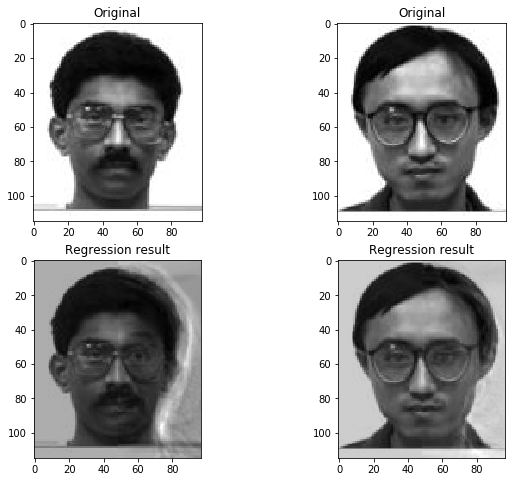

In [22]:
 test_predict_face()

(ii) Regularization is important for avoiding over-fitting on a noisy data input. For the case of images, the model has too much weights and so, regularization might help to improve results significantly.

* Implement function `ii_predict_face_reg` that solves the problem from Exercise 3 using ridge regression.
It should take the same arguments as `ii_function_predict_face`, except for an additional argument which is the regularization strength $\lambda$.

You can use function `test_predict_face_reg` to test your implementation.

* Research, how the choice of $\lambda$ contributes to the results.
* Report your findings.

In [23]:
from sklearn.linear_model import Ridge

In [24]:
def ii_predict_face_reg(d, q, lam):
    #d = train subset (d_train)
    #q = query subset
    
    N_samples,height,width  = d.shape
    wh = width*height
    width_index = int(width/2)
    left_train = d[:,:198,:width_index]
    right_train = d[:,:198,width_index+1:] 
    leftTrainImages = np.reshape(left_train, (left_train.shape[0],left_train.shape[1]*left_train.shape[2]))
    rightTrainImages = np.reshape(right_train, (right_train.shape[0],right_train.shape[1]*right_train.shape[2]))
    #width_left = d[:,:,:width_index].shape[2]
    #left_train = np.zeros((N_samples,height*d[:,:,:width_index].shape[2]))
    #right_train = np.zeros((N_samples,height*d[:,:,width_index:].shape[2]))
    #for i in range(N_samples):
        #left_train[i,:] = np.reshape(d[i,:,:width_index],(1,width_left*height))
        #right_train[i,:] = np.reshape(d[i,:,width_index:],(1,(width -width_left)*height))
        
    clf = Ridge(alpha = lam)
    #clf.fit(left_train,right_train)
    clf.fit(leftTrainImages,rightTrainImages)

    leftValImages = np.reshape(q, (q.shape[0],q.shape[1]*q.shape[2]))

    y_val = clf.predict(leftValImages)

    #y_predict = np.reshape(y_val, (query.shape[0],right_train[1],right_train[2])
    y_predict = np.reshape(y_val, (q.shape[0],right_train.shape[1],right_train.shape[2]))
    
    return y_predict

In [25]:
from sklearn.metrics import mean_squared_error

In [26]:
def test_predict_face_reg(lam):
    dataset = []

    #location of the dataset
    DATA_FOLDER = './materials/small_dataset/'
    
    #load image in dataset variable
    for f in os.listdir(DATA_FOLDER):
        if f.endswith('jpg'):
            path = os.path.join(DATA_FOLDER, f)
            dataset.append(plt.imread(path))
    
    #convert the list into numpy array
    dataset = np.asarray(dataset, dtype=np.float32)
    
    #split data into train and val subsets randomly
    #dataset has 165 images of dimension(height x width)= (115,98)
    d_train, d_val = train_test_split(dataset)
    
    #query has dimensions (subset_size, 115, 49)
    query = d_val[:, :, :d_val.shape[-1] // 2]
    
    #call the ii_predict_face function to calculate theta and prediction
    prediction = ii_predict_face_reg(d_train, query, lam)
    
    query_val = d_val[:, :, d_val.shape[-1] // 2+1:]
    RMSE = []
    for k in range(query_val.shape[0]):
        qVal_i = np.reshape(query_val[k],(1,query_val[k].shape[0]*query_val[k].shape[1]))
        predVal_i =np.reshape(prediction[k],(1, prediction[k].shape[0]*prediction[k].shape[1])) 
        RMSE.append(mean_squared_error(qVal_i, predVal_i, squared= False))
    
    RMSE_avg = np.mean(RMSE)
    print(f"lambda = {lam} with average RMSE: {RMSE_avg}")
    
    #combine the query part of image with the prediction image
    predicted_full = np.concatenate((query, prediction), axis=2)
    
    

    #choose a random image for prediction from query subset
    i = np.random.choice(len(d_val) - 1)
    
    

    #plotting results
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))
    
    ax[0, 0].imshow(d_val[i], cmap=plt.cm.gray)
    ax[0, 0].set_title('Original')

    ax[1, 0].imshow(predicted_full[i], cmap=plt.cm.gray)
    ax[1, 0].set_title('Regression result')

    ax[0, 1].imshow(d_val[i + 1], cmap=plt.cm.gray)
    ax[0, 1].set_title('Original')
    
    ax[1, 1].imshow(predicted_full[i + 1], cmap=plt.cm.gray)
    ax[1, 1].set_title('Regression result')
    
    return RMSE_avg

C:\Users\Ketzel\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


lambda = 0.01 with average RMSE: 39.52014923095703


C:\Users\Ketzel\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


lambda = 0.1 with average RMSE: 38.748252868652344


C:\Users\Ketzel\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.789469e-10
  overwrite_a=False)


lambda = 1.0 with average RMSE: 37.51502227783203


C:\Users\Ketzel\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.450667e-09
  overwrite_a=False)


lambda = 10.0 with average RMSE: 37.77924728393555


C:\Users\Ketzel\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.448646e-08
  overwrite_a=False)


lambda = 100.0 with average RMSE: 36.47073745727539
lambda = 1000.0 with average RMSE: 37.220272064208984


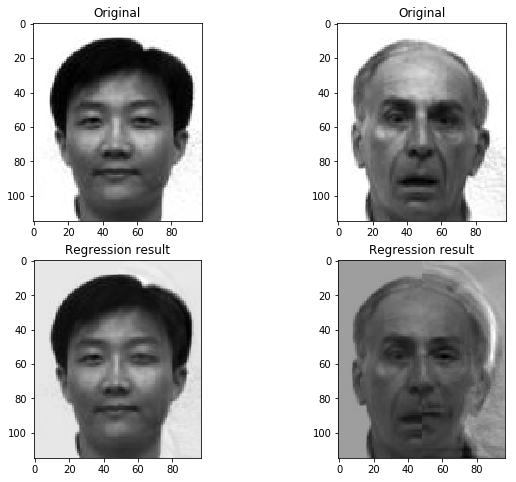

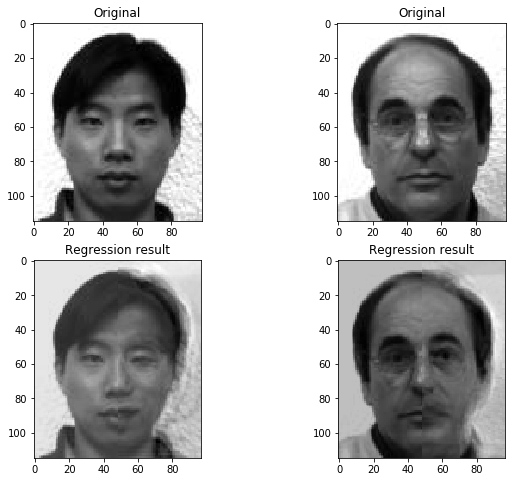

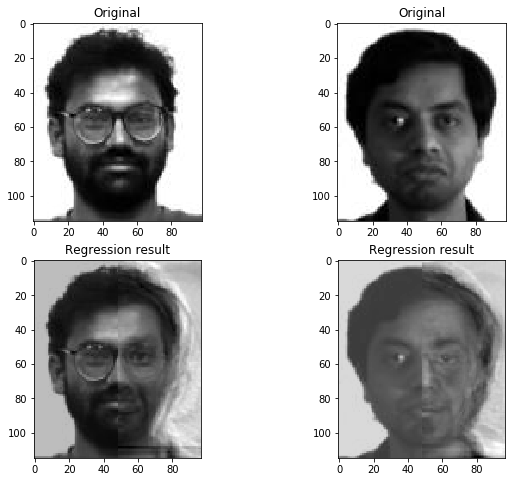

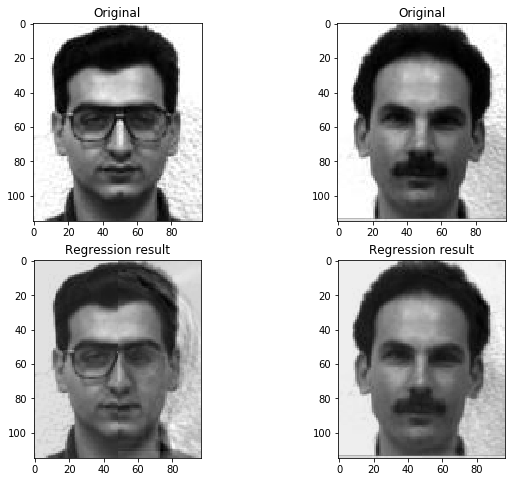

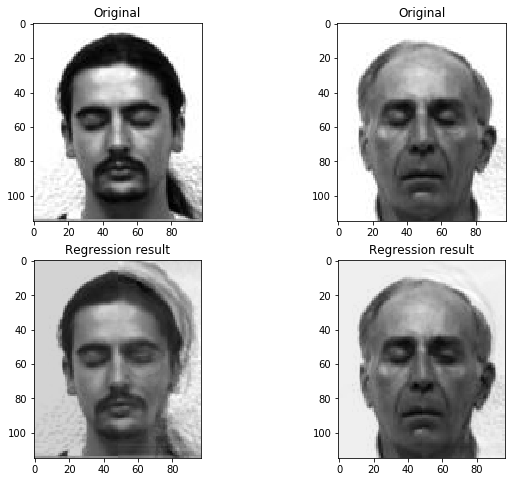

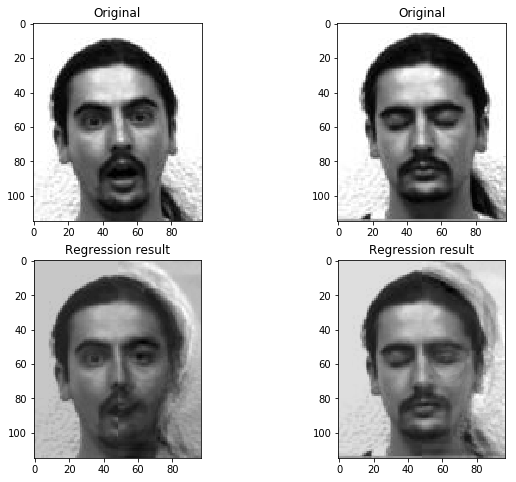

In [28]:
lambdas = np.logspace(-2,3, num = 6)
RMSE_avg_list = []
for lam in lambdas:
    RMSE_avg_list.append(test_predict_face_reg(lam))


### 2.* --- Bonus Problem 

Solve problems from Exercise 3 for dataset of bigger images. For this problem, create copy of `ii_predict_face_reg` add to its names postfix `_big`.

The problem here is the size. Analytical method requires expensive operation (matrix inversion, see (Normal Equation)). After the introduction of regularizer, the total size of the problem becomes too big. Estimate the size of matrices for closed form solution of this problem (report it) and you will see that inversion of this matrix is too expensive (it requires O($n^3$) operations).

What could be done: iterative methods (see gradient descent (GD) and stochastic average gradient (SAG)) or use extremely powerful PC :).

To test your solution use `test_predict_face_reg_big`.

In [84]:
 #Unfortunately, it doesn't work in the end :/
    
    
    
def ii_predict_face_reg_big(d, q, lam):

    tol = 1  # finish criterion
    max_it = 10 # maximum iterations
    
    #extract left and right part of image from the train subset
    N_samples,height,width  = d.shape
    width_index = int(width/2)
    left_train = d[:,:198,:width_index]
    right_train = d[:,:198,width_index+1:] 
    leftTrainImages = np.reshape(left_train, (left_train.shape[0],left_train.shape[1]*left_train.shape[2]))
    rightTrainImages = np.reshape(right_train, (right_train.shape[0],right_train.shape[1]*right_train.shape[2]))
    

    N_y = rightTrainImages.shape[1] # anount of features per image

    RMSE_cur_total = 0
    RMSE_prev = 0
    ## Initialiazing parameters
    thetas = np.ones((leftTrainImages.shape[1],N_y))
    betas = np.ones((N_samples,N_y))
    
    
    for it in range(max_it):

        RME_prev = RMSE_cur_total ## Update RMSE
        RMSE_cur_total = 0
        
        for feat in range(N_y): #going through every feature of the output
            RMSE_cur = 0
            y_temp = rightTrainImages[:,feat]
            theta = thetas[:,feat]
            beta = betas[:,feat]
            x = leftTrainImages
            
            error = y_temp-(np.matmul(x,theta)+b) ## Caculate error
            RMSE_cur = np.sum(error**2)
            RMSE_cur_total += RMSE_cur # Adding the value to total of the Objective function
            
            ## Update Parameters with Gradient
            thetas[:,feat] = theta + lam*2/N_samples*np.matmul(x.T,error)
            betas[:,feat] = beta + lam*2/N_samples*np.matmul(np.ones(N_sample),error)
        
        ## Check if met breaking criteria
        if np.abs(RMSE_cur_total - RMSE_prev) < tol:
            break
        
    ## Prediction
    leftValImages = np.reshape(q, (q.shape[0],q.shape[1]*q.shape[2]))

    y_val = np.matmul(leftValImages,thetas) + betas

    #y_predict = np.reshape(y_val, (query.shape[0],right_train[1],right_train[2])
    y_predict = np.reshape(y_val, (q.shape[0],right_train.shape[1],right_train.shape[2]))

    return predict

In [87]:
def test_predict_face_reg_big():
    dataset = []

    #location of the dataset
    DATA_FOLDER = './materials/small_dataset/'
    
    #load image in dataset variable
    for f in os.listdir(DATA_FOLDER):
        if f.endswith('jpg'):
            path = os.path.join(DATA_FOLDER, f)
            dataset.append(plt.imread(path))
        
    #convert the list into numpy array
    dataset = np.asarray(dataset, dtype=np.float32)
    
    #split data into train and val subsets randomly
    #dataset has 165 images of dimension(height x width)= (115,98)
    d_train, d_val = train_test_split(dataset)
    
    #query has dimensions (subset_size, 115, 49)
    query = d_val[:, :, :d_val.shape[-1] // 2]
    
    #call the ii_predict_face_reg function to calculate theta and prediction
    prediction = ii_predict_face_reg_big(d_train, query, 1e2)
    
    #combine the query part of image with the prediction image
    predicted_full = np.concatenate((query, prediction), axis=2)

    #choose a random image for prediction from query subset
    i = np.random.choice(len(d_val) - 1)

    #plotting results
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))
    
    ax[0, 0].imshow(d_val[i], cmap=plt.cm.gray)
    ax[0, 0].set_title('Original')

    ax[1, 0].imshow(predicted_full[i], cmap=plt.cm.gray)
    ax[1, 0].set_title('Regression result')

    ax[0, 1].imshow(d_val[i + 1], cmap=plt.cm.gray)
    ax[0, 1].set_title('Original')
    
    ax[1, 1].imshow(predicted_full[i + 1], cmap=plt.cm.gray)
    ax[1, 1].set_title('Regression result')

In [88]:
 test_predict_face_reg_big()

ValueError: shapes (5635,123) and (5520,123) not aligned: 123 (dim 1) != 5520 (dim 0)

 ## Exercise 3 --- Random Forest (3 points)
 
 Now we will implement random forest classifier. Let's remember that the idea is to partition the input space
 and run piece-wise linear regression that maximize the prediction power.
 
Given a dataset $\mathcal{D} = \{x, y\}$ we define a function $f_{\theta_0,\theta_1, \sigma}$. Where we use $\sigma$ to split the input space from $x$ such that:
 
 $$Error_{\text{before}} = \sum_{x} (y - \theta^Tx_i)^2 $$
 
 
 $$Error_{\text{after}} = \sum_{x < \sigma_0} (y - \theta_0^Tx_i)^2  + \sum_{x > \sigma_0} (y - \theta_1^Tx_i)^2 $$

In practice, we can use much more $\sigma$'s to partition the input space are used, these are usually hierarchical (hence the tree term). For simplicity we will program a regression tree with `nsplits`, this will be randomly defined.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

First let's simulate some data, and make the traditional train, test split:

In [ ]:
N = 200


np.random.seed(1)
x = np.random.normal(0, 5, N)
f = lambda x:  np.sin(x)* x**2 + 100
y = f(x) + 3*np.random.normal(-3, 3, N)
x_ =  np.stack((np.ones_like(x),x),axis=-1)
# DATASET
x_train, x_test, y_train, y_test = train_test_split(x_,y)

id_sorted = np.argsort(x_test[:,1])
x_test, y_test = x_test[id_sorted] , y_test[id_sorted]

plt.scatter(x_train[:,1], y_train, marker='x', label='train')
plt.scatter(x_test[:,1], y_test, marker='.', label='test')


## GT 

x_gt = np.linspace(-15,15,10000)

plt.plot(x_gt,f(x_gt), 'black', label='GT')

plt.xlim(x.min()-1,x.max()+1)

plt.legend()

### 3.1 --- Question

Why do we need to add a line of 0's to x?

`x_ =  np.stack((np.ones_like(x),x),axis=-1)`



In [ ]:
#### I assume a line of 1's to x: This is needed to make the output stetic between the different of the input space

In [ ]:
def fit_linear(x,y):
    theta, sse,_,_ = np.linalg.lstsq(x, y,rcond=None)
    mse = sse / x.shape[0]
    return theta, mse

def predict_tree(x_in, model):
    y_out = np.zeros(x_in.shape[0])
    for i, x in enumerate(x_in):
        for interval, theta in model.items():
            if x[1] > interval[0] and x[1] < interval[1]:
                y_out[i] = np.dot(x, theta)
    return y_out
        

### 3.2 --- Complete the `regression_tree` function.

First define randomly the sigma parameters (i.e. the thresholds where we will partition x).
Hints: Don't forget to add `-np.inf` and `np.inf` to the set of sigma parameters to take into account the complete range. Sorting sigma makes things easier.

Ex. if nsplits = 3
sigma should be of the form 
$$\sigma = (-inf, -0.5 , 0.35, 1.55, inf)$$



In [ ]:
print(x_train.shape)

In [ ]:
def regression_tree(x,y, nsplits=1, seed=None):
    '''
    Returns
    -------
    model_out : dictionary
    Each key represents the interval range from input x and
    the item is the theta of a linear regression.

    '''
    

    model_out = dict()
    
    np.random.seed(seed)
    x_temp = x[:,1]
    x_temp.sort()
    sigma = np.random.choice(x_temp, size= nsplits, replace= True)
    sigma = np.append(sigma,np.Inf)
    sigma = np.append(sigma,-np.Inf)
    sigma = np.sort(sigma)
    
    

    for n_ in range(nsplits+1):

        # index should be a boolean indicator to filter samples inside the range of interest
        min_ = sigma[n_]
        max_ = sigma[n_+1]
        
        index = np.where((x_temp > min_) & (x_temp <= max_) )
        
        theta, mse = fit_linear(x_train[index],y_train[index])
        model_out[(min_, max_)] = theta
    return model_out 

In [ ]:
# now we can train the model 
model = regression_tree(x_train, y_train,nsplits=7, seed=2)

# model keys are the piece-wise intervals and
# contains the theta from the linear regression

model.keys()


In [ ]:
# predict on the test set
y_pred = predict_tree(x_test,model)

### 3.3 --- Question

What is the Mean Squared Error on the test set? Which is the best value for `nsplits`?

In [ ]:
from sklearn.metrics import mean_squared_error
plt.scatter(x_train[:,1], y_train, marker='x', label='train')
plt.scatter(x_test[:,1], y_test, marker='.', label='test')
plt.plot(x_test[:,1],y_pred, 'red', label = 'predicted')

plt.legend()

mse = mean_squared_error(y_pred, y_test, squared= True)

plt.title(f'MSE {mse:.2f}')

### 3.4 --- Ensemble of trees.

The real advatange of random trees is to train several random trees and make an ensemble of 
predictions.

Complete the following code to compute an ensemble of predictions. Does it improve the performance? How many random trees would you choose?

In [ ]:
ntrees = 20

model_list = []
for n in range(ntrees):
    model_ = regression_tree(x_train, y_train,nsplits=6, seed=2)
    model_list.append(model_)

In [ ]:
y_predictions = []

for model_ in model_list:
    y_pred_ = predict_tree(x_test,model_)
    y_predictions.append(y_pred_)
    
y_predictions = np.stack(y_predictions)
y_ensemble = np.mean(y_predictions, axis = 0)

In [ ]:
ss = np.array([[1,2,3],[3,4,2]])
print(ss, '\n', np.mean(ss, axis = 1), '\n', y_predictions.shape, '\n', y_ensemble.shape, '\n', y_test.shape)

In [ ]:
plt.scatter(x_train[:,1], y_train, marker='x', label='train')
plt.scatter(x_test[:,1], y_test, marker='.', label='test')
plt.plot(x_test[:,1],y_ensemble, 'red', label = 'predicted')

plt.legend()

mse = mean_squared_error(y_ensemble,y_test, squared= True)

plt.title(f'MSE {mse:.2f}')

## Exercise 4 --- RANSAC (3 Points)

RAndom SAmpling Consensus (RANSAC) is a method for estimating parameters that is particularly effective when dealing with outliers.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
import cv2
from utils import *

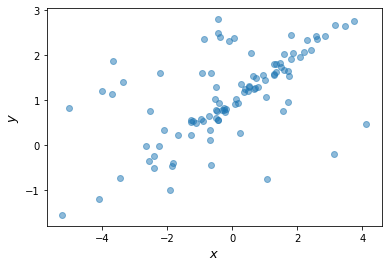

In [2]:
data = np.load("materials/RANSAC_data.npz")
x = data["x"]
y = data["y"]

plot_linear_model_and_data(data=(x,y))

### 4.1 --- MMSE estimator

we know that the data comes from a linear model of the form:
$$ y = m x + q + \epsilon $$
where $\epsilon$ denotes some noise in the observations.

write the function `MMSE_estimator` wich receives as input the arrays `x` and `y` and returns the minimum mean square error estimator for the parameters of the linear model `m` and `q`.

In [5]:
def MMSE_estimator(x,y):
    # source: https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-011-introduction-to-communication-control-and-signal-processing-spring-2010/readings/MIT6_011S10_chap08.pdf
    
    cov = np.cov(np.vstack((x,y)))
    
    m = cov[1,0]/(cov[1,1]**2)
    q = np.mean(y)- np.mean(x)*m
    
    return m,q



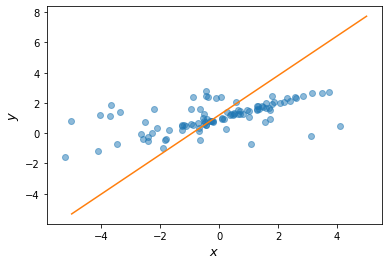

MMSE estimator: m=1.308 q=1.199


In [6]:
m_mmse, q_mmse = MMSE_estimator(x,y)

plot_linear_model_and_data(m=m_mmse,q=q_mmse,data=(x,y))
print("MMSE estimator: m={:.3f} q={:.3f}".format(m_mmse,q_mmse))

### 4.2 --- RANSAC

we now want to use RANSAC to improve the quality of our estimate. first write the function `is_inlier` which receives as input the model parameters, a data point (or a vector of data points, as you prefer), and a threshold $\delta$; it returns True if the data point is within the tolerance and False otherwise.

In [7]:
def is_inlier(m,q,x,y,delta):
    """
        m,q: parameters if the linear model
        x,y: data point
        delta: tolerance for considering a point as inlier or outlier
    """
    
    inlier = y-x*m-q
    
    return np.sum(1*(inlier <= delta))
        

Write now the RANSAC iterative procedure using the functions `is_inlier` and `MMSE_estimator`.

In [8]:
delta = 0.2
inlier = y-x*m_mmse-q_mmse
print(np.sum(1*(inlier <= delta)))

60


In [9]:
best_N_inliers = -1
best_model = None

max_iterations = 200 # maximum number of iterations
M = 70  # number of subsample of whole dataset extracted in each iteration
delta = 0.1 # tolerance for considering a point an inlier

for i in range(max_iterations):
    
    # sample M data points
    sample_index = np.random.choice(len(x) - 1, size = M, replace = True)
    x_temp = x[sample_index]
    y_temp = y[sample_index]
    # fit the model with randomly sampled points using the MMSE estimator
    m, q = MMSE_estimator(x_temp,y_temp)
    
    # count the number of inliers using the estimated model
    N_inliers = is_inlier(m,q,x,y,delta)
    # save the model parameters in case they are the best 
    if N_inliers > best_N_inliers:
        best_model = m,q
        best_N_inliers = N_inliers

print('best model explains: {}% points'.format(100*best_N_inliers/100.))
print('\n', best_N_inliers)
m_ransac, q_ransac = best_model

best model explains: 76.0% points

 76


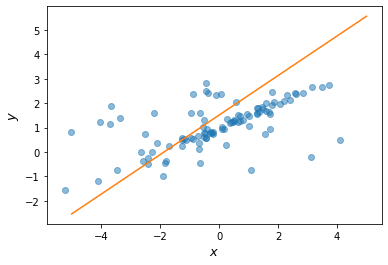

RANSAC estimate: m=0.809 q=1.510


In [10]:
plot_linear_model_and_data(m=m_ransac,q=q_ransac,data=(x,y))
print("RANSAC estimate: m={:.3f} q={:.3f}".format(m_ransac,q_ransac))

Answer the following questions:
- which method provides the best results? MMSE or RANSAC?
- what is a good value for $M$ and $\delta$ in this case? motivate your answer.
- if we assume the probabilty for each point to be an inlier is equal to 0.7, what should be the value of `max_iterations` in order to hace that at least in one iteration the subsampled dataset is free of outliers?

#### Answer here:

### 4.3 --- RANSAC for image stitching 

we now want to use RANSAC to perform image stitching. Image stitching basically consists in stitching together two images which have some overlapping parts.

Of course in order to do this one image must be transformed (translated, rotated...) so that the part of the scene that appears in both images is "aligned".

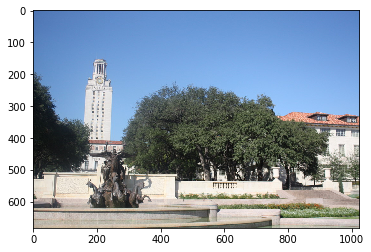

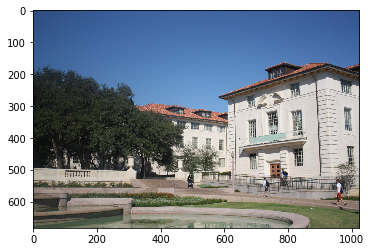

In [11]:
img1,img2 = load_and_show_images()

The first step is to find the correspondences within the two images, which means find the pixels in the two images which correspond to the same spot in the 3D scene. This part is already done and it is provided to you:

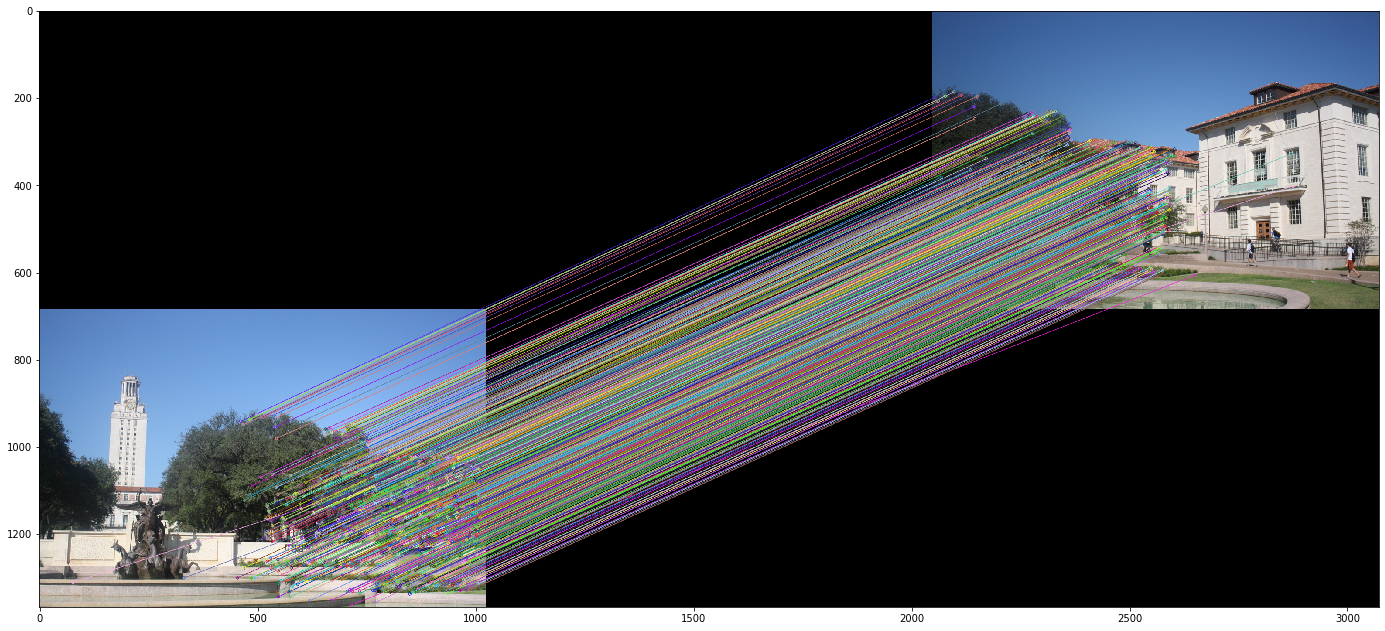

In [12]:
kp1,kp2 = load_correspondences()

In the image it is possible to see the corresponedences that are available in the images. The goal is to use these correspondences to estimate how the image 2 needs to be transformed in order to be stitched to image 1. The vectors `kp1` and `kp2` are arrays of size $N\times 2$, and contain the pixel coordinates of the correspondences for image 1 and image 2.

You are provided with the function `estimate_transformation_matrix` which receives as input two arrays of siye $M \times 2$ of corespondences and estimates the matrix `H` which can then be used to map each pixel of image 2 to a pixel of image 1.

Moreover you are provided with the function `transform_points` which receives as input coordinates of pixels (correspondences) in image 2 and maps them to image 1 using the transformation matrix `H`

write the function `is_inlier_stitching` which receives as input two arrays of coordinates and checks if the coordinates are pairwise within some threshold $\delta$ 

In [13]:
def is_inlier_stitching(kp1,kp2_transformed,delta):
    """
        kp1: correspondence point in image 1
        kp2_transformed: correspondence point mapped from image 2 to image 1
        delta: tolerance for considering a point as inlier or outlier
    """
    
    inlier = np.linalg.norm(kp1-kp2_transformed,ord=2,axis=1) <= delta

    return 1*inlier

complete the following RANSAC method:

In [14]:
best_N_inliers = -1
best_model = None
max_iterations = 2000 #maximum number of iterations
M = 700  # number of subsample of whole dataset extracted in each iteration
delta = 6 # tolerance for considering a point an inlier


for i in range(max_iterations):
    
    # sample M correspondences from kp1 and 
    idx1 = np.random.randint(kp1.shape[0], size = M)
    kp1_sample = kp1[idx1,:]
    kp2_sample = kp2[idx1,:]
    
    # fit the model with randomly sampled correspondences
    H = estimate_transformation_matrix(kp1_sample,kp2_sample)
    
    # transforms all correspondences from image 2 to image 1
    kp2_transformed = transform_points(kp2,H)
    
    # now check how many points of kp2_transformed are close to the corresponding point kp_1
    # use:
    # is_inlier_stitching(kp2_transformed,kp1,delta)
    N_inliers = np.sum(is_inlier_stitching(kp2_transformed,kp1,delta))
        
    # save the model parameters in case they are the best 
    if best_N_inliers <= N_inliers:
        best_model = H
        best_N_inliers = N_inliers
    
print('best model explains: {:.3f}% points'.format(100 * best_N_inliers/kp1.shape[0]))

H = best_model

best model explains: 98.196% points


In [15]:
print(H.shape)

(3, 3)


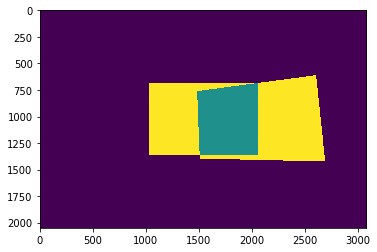

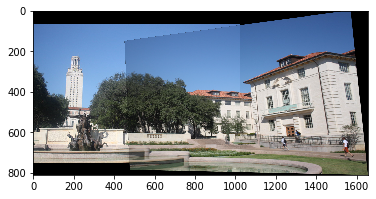

In [16]:
img,mask = blending(img1,img2,H)

plt.imshow(mask)
plt.show()

plt.imshow(img[:,:,[2,1,0]])
plt.show()

_ = cv2.imwrite('stitching.jpg', img)

- considering that the transformation matrix $H$ has 8 degrees of freedom, what is a good value of $M$ in this case?
- How do you empirically select in this case the value of $\delta$?

#### Answer here

In [60]:
# Source: https://cs.gmu.edu/~kosecka/cs682/lect-fitting.pdf
#### Question 1: due to the outlier ratio around 1.5% a good consensus subset size could be 985 but it has to be at least 8

#### Question 2:Choose delta so probability for inlier is p (in this case around 98%) -->